# Исследование тарифного плана  компании «Мегалайн»

Предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

Описание тарифов:

**Тариф «Смарт»**

1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
    * минута разговора: 3 рубля
    * сообщение: 3 рубля
    * 1 Гб интернет-трафика: 200 рублей

**Тариф «Ультра»**

1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
    * минута разговора: 1 рубль
    * сообщение: 1 рубль
    * 1 Гб интернет-трафика: 150 рублей

**Примечание:**

«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

## Шаг 1. Откройте файл с данными и изучите общую информацию

### Знакомство с данными

In [2]:
# для начала импортируем все библиотеки, которые могут понадобиться
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats as st
import numpy as np

In [3]:
#читаем файлы с данными и сохраняем в переменные
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

In [4]:
#смотрим первые 5 строк каждого датасета и выводим информацию о нем
tables = [calls, internet, messages, tariffs, users]
for table in tables:
    display(table.head())
    table.info()
    print()
    print()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB




,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB




,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB




,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes




,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB




In [5]:
users[users['churn_date'] == "'2018-08-31T00:00:00.000000000'"]

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff


### Выводы

При оценке данных обнаружено, что пропущенные значения присутствуют в данных **users** в столбце `churn_date`, которая показывает дату выхода абонента из тарифного плана. Пропуск означает, что такой даты нет и на момент выгрузки абонент сети пользуется данным тарифом.

В данных **calls** обнаружены звонки с нулевой длительностью. По условиям задачи это не ошибка, ведь нулями обозначены пропущенные звонки, поэтому их не нужно удалять.

В данных **internet** обнаружен столбец 'Unnamed: 0' который дублирует индексы строк, поэтому его можно убрать из этих данных. Считаю, что это не будет ошибкой, а сам дата сет станет "легче" и будет быстрее обрабатываться памятью.

Почти в каждом датасете мы имеем какой-либо столбец, в котором хранятся данные о времени. Таким значениям необходимо изменить тип данных со смешанного типа object на значение даты и времени.


## Шаг 2. Подготовьте данные

### Привидение данных к нужным типам

Для работы со значением даты и времени воспользуется специальным методом **to_datetime**

In [6]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

### Удалить столбец 'Unnamed: 0' в данных **internet** (дублирует индексы)

In [7]:
internet = internet.drop(columns = ['Unnamed: 0'],axis = 1)

In [8]:
internet.head()
#выведем первые 5 строк для проверки

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


Столбца 'Unnamed: 0' больше нет с нами ))

1) Рассмотрим гистограмму распределения длительности звонков, таким образом увидим, есть ли аномалии или нет?

In [9]:
calls['duration'].describe()

count    202607.000000
mean          6.755887
std           5.843365
min           0.000000
25%           1.300000
50%           6.000000
75%          10.700000
max          38.000000
Name: duration, dtype: float64

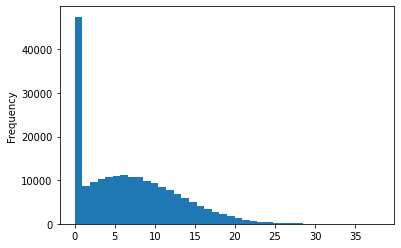

In [10]:
calls['duration'].plot(kind='hist', bins=40)
plt.show()

* Итак, по результатам описательной статистики и на гистограмме видно, что максимальная длина звонков - 38 минут. Минимальная 0. По условиям, если продолжительность звонков равна 0 - это пропущенные звонки. Эти значения мы не трогаем, но здесь можно посмотреть на количество звонков продолжительность до полуминуты.

In [11]:
calls[(calls['duration'] > 0) & (calls['duration'] < 0.5)]

,id,call_date,duration,user_id
55,1000_55,2018-09-19,0.31,1000
65,1000_65,2018-10-28,0.34,1000
97,1000_97,2018-10-26,0.33,1000
122,1000_122,2018-10-07,0.13,1000
135,1000_135,2018-10-25,0.02,1000
...,...,...,...,...
202318,1498_111,2018-10-17,0.46,1498
202322,1498_115,2018-10-02,0.49,1498
202438,1499_51,2018-10-08,0.47,1499
202452,1499_65,2018-11-30,0.20,1499


В принципе у нас 4 тыс. записей с продолжительностью от 1 до 30 сек. Так что большое количество пропущенных не ошибка.

2) Рассмотрим гистограмму распределения использованных мегабайт

In [12]:
internet['mb_used'].describe()

count    149396.000000
mean        370.192426
std         278.300951
min           0.000000
25%         138.187500
50%         348.015000
75%         559.552500
max        1724.830000
Name: mb_used, dtype: float64

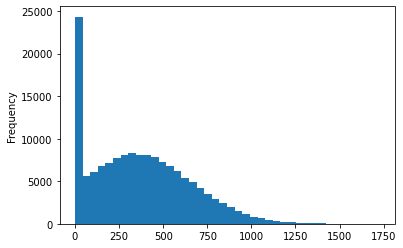

In [13]:
internet['mb_used'].plot(kind='hist', bins=40)
plt.show()

В данных об использованных мегабайтах тоже нет выбивающихся значений. Мы видим что медианное значение за сессию 348 Мб, а максимально за сессию 1,7 Гб. Нулевые значения я не удаляю, интернет может быть включен, но человек может ничего не скачиваеть и не смотреть в данный момент.

3) Теперь рассмотрим на данные по смс (они есть выше)

In [14]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


Тут данные полные и пропусков не обнаружено, получается, что 1 запись - 1 сообщение.

### Рассчитываем характеристики для каждого пользователя:
1) количество сделанных звонков и израсходованных минут разговора по месяцам;

2) количество отправленных сообщений по месяцам;

3) объем израсходованного интернет-трафика по месяцам;

4) помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; 


#### КОЛИЧЕСТВО СДЕЛАННЫХ ЗВОНКОВ И ИЗРАСХОДОВАННЫХ МИНУТ

In [15]:
# для работы добавляем столбец с обозначением месяца
calls['month'] = calls['call_date'].dt.month

In [16]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
 4   month      202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 7.7+ MB


In [17]:
calls['duration'] = np.ceil(calls['duration'])
calls.head()

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0.0,1000,7
1,1000_1,2018-08-17,0.0,1000,8
2,1000_2,2018-06-11,3.0,1000,6
3,1000_3,2018-09-21,14.0,1000,9
4,1000_4,2018-12-15,6.0,1000,12


In [18]:
group_calls = np.ceil(calls.pivot_table(index = ['user_id', 'month'], values = ['id', 'duration'],
                            aggfunc={'id':'count', 'duration':'sum'})).reset_index()

In [19]:

group_calls = group_calls.rename(columns = {'user_id':'user_id', 'month': 'month', 'duration': 'duration', 'id':'calls'})
group_calls.head(15)

,user_id,month,duration,calls
0,1000,5,159.0,22.0
1,1000,6,172.0,43.0
2,1000,7,340.0,47.0
3,1000,8,408.0,52.0
4,1000,9,466.0,58.0
5,1000,10,350.0,57.0
6,1000,11,338.0,43.0
7,1000,12,333.0,46.0
8,1001,11,430.0,59.0
9,1001,12,414.0,63.0


#### Количество отправленных сообщений по месяцам

In [20]:
# для работы добавляем столбец с обозначением месяца
messages['month'] = messages['message_date'].dt.month

In [21]:
messages.head(10)

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12
5,1000_5,2018-06-20,1000,6
6,1000_6,2018-11-19,1000,11
7,1000_7,2018-10-29,1000,10
8,1000_8,2018-06-25,1000,6
9,1000_9,2018-12-18,1000,12


In [22]:
#по пользователю и месяцу производим группировку с рассчетом количества отправленных сообщений

group_message = messages.pivot_table(index=['user_id', 'month'], values='id', aggfunc='count').reset_index()
group_message = group_message.rename(columns = {'user_id':'user_id', 'month':'month', 'id':'messages'})
group_message.head(10)

,user_id,month,messages
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
5,1000,10,73
6,1000,11,58
7,1000,12,70
8,1002,6,4
9,1002,7,11


#### Объем израсходованного интернет-трафика по месяцам

In [23]:
# для работы добавляем столбец с обозначением месяца
internet['month'] = internet['session_date'].dt.month
internet.head()

,id,mb_used,session_date,user_id,month
0,1000_0,112.95,2018-11-25,1000,11
1,1000_1,1052.81,2018-09-07,1000,9
2,1000_2,1197.26,2018-06-25,1000,6
3,1000_3,550.27,2018-08-22,1000,8
4,1000_4,302.56,2018-09-24,1000,9


In [24]:
#по пользователю и месяцу производим группировку с объема трафика

#internet.head()
group_internet = internet.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc='sum').reset_index()


group_internet.head(16)

,user_id,month,mb_used
0,1000,5,2253.49
1,1000,6,23233.77
2,1000,7,14003.64
3,1000,8,14055.93
4,1000,9,14568.91
5,1000,10,14702.49
6,1000,11,14756.47
7,1000,12,9817.61
8,1001,11,18429.34
9,1001,12,14036.66


#### Помесячная выручка с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика

In [25]:
# оставляем значение пользователя и тарифа
users_1 = users[['user_id', 'tariff']]
users_1.head()

,user_id,tariff
0,1000,ultra
1,1001,smart
2,1002,smart
3,1003,ultra
4,1004,ultra


In [26]:
#mediumm = pd.merge(users_1, group_calls, on=('user_id'), how='left').reset_index()
medium_table = pd.merge(group_calls, group_message, on=['user_id', 'month'], how='outer').reset_index(drop=True)

In [27]:
medium_table.head()

,user_id,month,duration,calls,messages
0,1000,5,159.0,22.0,22.0
1,1000,6,172.0,43.0,60.0
2,1000,7,340.0,47.0,75.0
3,1000,8,408.0,52.0,81.0
4,1000,9,466.0,58.0,57.0


In [28]:
mediummm = pd.merge(medium_table, group_internet, on=['user_id', 'month'], how='outer').reset_index(drop=True)

In [29]:
mediummm.head()

,user_id,month,duration,calls,messages,mb_used
0,1000,5,159.0,22.0,22.0,2253.49
1,1000,6,172.0,43.0,60.0,23233.77
2,1000,7,340.0,47.0,75.0,14003.64
3,1000,8,408.0,52.0,81.0,14055.93
4,1000,9,466.0,58.0,57.0,14568.91


In [30]:
final_data = pd.merge(mediummm, users_1, on='user_id', how='outer').reset_index(drop=True)

In [31]:
final_data.head(15)

,user_id,month,duration,calls,messages,mb_used,tariff
0,1000,5.0,159.0,22.0,22.0,2253.49,ultra
1,1000,6.0,172.0,43.0,60.0,23233.77,ultra
2,1000,7.0,340.0,47.0,75.0,14003.64,ultra
3,1000,8.0,408.0,52.0,81.0,14055.93,ultra
4,1000,9.0,466.0,58.0,57.0,14568.91,ultra
5,1000,10.0,350.0,57.0,73.0,14702.49,ultra
6,1000,11.0,338.0,43.0,58.0,14756.47,ultra
7,1000,12.0,333.0,46.0,70.0,9817.61,ultra
8,1001,11.0,430.0,59.0,NaN,18429.34,smart
9,1001,12.0,414.0,63.0,NaN,14036.66,smart


In [32]:
final_data['duration'].sum()

1450301.0

In [33]:
calls['duration'].sum()

1450301.0

In [34]:
final_data['mb_used'].sum()

55305267.73

In [35]:
internet['mb_used'].sum()

55305267.73

In [36]:
final_data['messages'].sum()

123036.0

In [37]:
messages['id'].count()

123036

In [38]:
final_data.head(15)

,user_id,month,duration,calls,messages,mb_used,tariff
0,1000,5.0,159.0,22.0,22.0,2253.49,ultra
1,1000,6.0,172.0,43.0,60.0,23233.77,ultra
2,1000,7.0,340.0,47.0,75.0,14003.64,ultra
3,1000,8.0,408.0,52.0,81.0,14055.93,ultra
4,1000,9.0,466.0,58.0,57.0,14568.91,ultra
5,1000,10.0,350.0,57.0,73.0,14702.49,ultra
6,1000,11.0,338.0,43.0,58.0,14756.47,ultra
7,1000,12.0,333.0,46.0,70.0,9817.61,ultra
8,1001,11.0,430.0,59.0,NaN,18429.34,smart
9,1001,12.0,414.0,63.0,NaN,14036.66,smart


Для того, чтобы дальнейшая функция корректно работала я предлагаю заменить пропущенные значения на 0. Считаю, что это вполне корректно, ведь если значение Nan или 0 - получается, что человек не пользовался либо звонками, либо интернетом, либо сообщениями.

Проверяем в каких столбцах у нас присутствуют пропуски для того, чтобы заменить их на 0

In [39]:
# проверяем в каких столбцах у нас присутствуют пропуски для того, чтобы заменить их на 0
final_data.isna().sum()


user_id       0
month         2
duration     42
calls        42
messages    499
mb_used      13
tariff        0
dtype: int64

In [40]:
final_data[final_data['month'].isna()]

,user_id,month,duration,calls,messages,mb_used,tariff
3214,1128,NaN,NaN,NaN,NaN,NaN,ultra
3215,1371,NaN,NaN,NaN,NaN,NaN,smart


На мой взгляд эти 2 строки не нужны нам в исследовании. Объем этих данных составляет 0.4% от общего датасета и вообще не несет никакой информации, кроме названия тарифа - мы не сможем как то заполнить пропущенные значения. Поэтому проще будет их удалить и забыть

In [41]:
final_data = final_data.dropna(axis='index', subset=['month']).reset_index(drop=True, inplace=False)

In [42]:
#заменяем пропущенные значения на 0
final_data['messages'] = final_data['messages'].fillna(0)
final_data['mb_used'] = final_data['mb_used'].fillna(0)
final_data['calls'] = final_data['calls'].fillna(0)
final_data['duration'] = final_data['duration'].fillna(0)
final_data.isna().sum()

user_id     0
month       0
duration    0
calls       0
messages    0
mb_used     0
tariff      0
dtype: int64

In [43]:
final_data.head(15)

,user_id,month,duration,calls,messages,mb_used,tariff
0,1000,5.0,159.0,22.0,22.0,2253.49,ultra
1,1000,6.0,172.0,43.0,60.0,23233.77,ultra
2,1000,7.0,340.0,47.0,75.0,14003.64,ultra
3,1000,8.0,408.0,52.0,81.0,14055.93,ultra
4,1000,9.0,466.0,58.0,57.0,14568.91,ultra
5,1000,10.0,350.0,57.0,73.0,14702.49,ultra
6,1000,11.0,338.0,43.0,58.0,14756.47,ultra
7,1000,12.0,333.0,46.0,70.0,9817.61,ultra
8,1001,11.0,430.0,59.0,0.0,18429.34,smart
9,1001,12.0,414.0,63.0,0.0,14036.66,smart


In [44]:
def make_profit (row):
    if row['tariff'] == 'smart':
        extra_minutes = row['duration'] - tariffs.loc[0, 'minutes_included'] #вычитаем из количества использованных минут тарифное значение
        extra_megabytes = row['mb_used'] - tariffs.loc[0, 'mb_per_month_included'] #по аналогии с минутами, только Мб интернета
        extra_sms = row['messages'] - tariffs.loc[0, 'messages_included'] #также сообщения
            
        if extra_minutes < 0: #если где-то разница меньше 0, значит перерасхода нет и доп.платежей не будет
            extra_minutes = 0
        if extra_megabytes < 0:
            extra_megabytes = 0
        if extra_sms < 0:
            extra_sms = 0
        return ((extra_minutes * tariffs.loc[0, 'rub_per_minute']) + 
                (np.ceil(extra_megabytes/1024)*tariffs.loc[0, 'rub_per_gb']) +
                (extra_sms * tariffs.loc[0, 'rub_per_message']) + tariffs.loc[0, 'rub_monthly_fee'])
        #np.ceil()округляет число вверх. Здесь мы округляем секунды в минуты, а также
        #гигабайты с точкой до целого числа.
        
    else:
        extra_minutes = row['duration'] - tariffs.loc[1, 'minutes_included']
        extra_megabytes = row['mb_used'] - tariffs.loc[1, 'mb_per_month_included']
        extra_sms = row['messages'] - tariffs.loc[1, 'messages_included']
            
        if extra_minutes < 0:
            extra_minutes = 0
            
        if extra_megabytes < 0:
            extra_megabytes = 0
            
        if extra_sms < 0:
            extra_sms = 0
        
        return ((extra_minutes*tariffs.loc[1, 'rub_per_minute'])+
                (np.ceil(extra_megabytes/1024)*tariffs.loc[1,'rub_per_gb'])+
                (extra_sms*tariffs.loc[1,'rub_per_message'])+tariffs.loc[1,'rub_monthly_fee'])
        
  

Помесячная выручка будет отображена в столбце 'earnings'. Он появится после применения функции make_profit. 

Также необходимо обозначить ось - axis=1

In [45]:

final_data['earnings'] = final_data.apply(make_profit, axis=1)

In [46]:
final_data.head(20)

,user_id,month,duration,calls,messages,mb_used,tariff,earnings
0,1000,5.0,159.0,22.0,22.0,2253.49,ultra,1950.0
1,1000,6.0,172.0,43.0,60.0,23233.77,ultra,1950.0
2,1000,7.0,340.0,47.0,75.0,14003.64,ultra,1950.0
3,1000,8.0,408.0,52.0,81.0,14055.93,ultra,1950.0
4,1000,9.0,466.0,58.0,57.0,14568.91,ultra,1950.0
5,1000,10.0,350.0,57.0,73.0,14702.49,ultra,1950.0
6,1000,11.0,338.0,43.0,58.0,14756.47,ultra,1950.0
7,1000,12.0,333.0,46.0,70.0,9817.61,ultra,1950.0
8,1001,11.0,430.0,59.0,0.0,18429.34,smart,1150.0
9,1001,12.0,414.0,63.0,0.0,14036.66,smart,550.0


### Выводы

В этом разделе мы сгруппировали помесячно для каждого пользователя данные об использованных минутах, мегабайтах интернет-трафика и отправленных сообщениях. Исправили тип данных для даты и времени на соответствующий. В датасете internet был обнаружен столбец, дублирующий индексы - было принято решение его удалить. 

Также была написана функция, которая посредством обработки необходимых значений возвращает нам в новый столбец 'earnings' размер выручки.

## Шаг 3. Проанализируйте данные


Нужно описать поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Необходимо рассчитать среднее количество, дисперсию и стандартное отклонение, построить гистограммы и описать распределения.

### Рассмотрим описательную статистику для двух тарифов


1) Для тарифа **ultra**

In [47]:
final_data[final_data['tariff'] == 'ultra'].describe()

,user_id,month,duration,calls,messages,mb_used,earnings
count,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000
mean,1263.094416,8.250761,526.623350,73.392893,49.363452,19468.805208,2070.152284
std,140.694908,2.871762,317.606098,43.916853,47.804457,10087.170752,376.187114
min,1000.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1950.000000
25%,1143.000000,6.000000,284.000000,41.000000,6.000000,11770.260000,1950.000000
50%,1277.000000,9.000000,518.000000,74.000000,38.000000,19308.010000,1950.000000
75%,1381.000000,11.000000,752.000000,104.000000,79.000000,26837.690000,1950.000000
max,1495.000000,12.000000,1673.000000,244.000000,224.000000,49745.690000,4800.000000


2) Для тарифа **smart**

In [48]:
final_data[final_data['tariff'] == 'smart'].describe()

,user_id,month,duration,calls,messages,mb_used,earnings
count,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000,2229.000000
mean,1246.506505,8.346792,417.934948,58.463437,33.384029,16208.386990,1289.973531
std,146.119496,2.920316,190.313730,25.939858,28.227876,5870.476681,818.404367
min,1001.000000,1.000000,0.000000,0.000000,0.000000,0.000000,550.000000
25%,1121.000000,6.000000,282.000000,40.000000,10.000000,12643.010000,550.000000
50%,1239.000000,9.000000,422.000000,60.000000,28.000000,16506.840000,1023.000000
75%,1376.000000,11.000000,545.000000,76.000000,51.000000,20042.930000,1750.000000
max,1499.000000,12.000000,1435.000000,198.000000,143.000000,38552.450000,6770.000000


ПРОМЕЖУТОЧНАЯ ОЦЕНКА

Опираясь на эти показатели уже можно сказать, что клиенты тарифа Smart по сравнению с теми, кто использует тариф Ultra совершают меньшее количество звонков, отсюда мы видим и меньшую среднюю продолжительность звонков 418 мин против 520 мин. Интернет трафик также используется в меньшем количестве в среднем на 3 Гб.

### Расчет среднего количества, дисперсии и стандартного отклонения. Построение гистограмм и описание распределения.

In [49]:
#группируем датасет по юзеру и отображаем медианное значение в столбцах
mean_values = final_data.groupby('user_id').median()

In [50]:
mean_values.head()

,month,duration,calls,messages,mb_used,earnings
user_id,,,,,,
1000,8.5,339.0,46.5,65.0,14312.42,1950.0
1001,11.5,422.0,61.0,0.0,16233.00,850.0
1002,9.0,214.0,33.0,11.0,17580.10,1150.0
1003,10.0,824.0,108.0,83.0,11356.89,1950.0
1004,8.5,132.5,21.5,154.5,17810.53,1950.0


In [51]:
# добавляем столбец с тарифом
meane_values = pd.merge(mean_values, users_1, on=('user_id'), how='left')
meane_values.head()

,user_id,month,duration,calls,messages,mb_used,earnings,tariff
0,1000,8.5,339.0,46.5,65.0,14312.42,1950.0,ultra
1,1001,11.5,422.0,61.0,0.0,16233.00,850.0,smart
2,1002,9.0,214.0,33.0,11.0,17580.10,1150.0,smart
3,1003,10.0,824.0,108.0,83.0,11356.89,1950.0,ultra
4,1004,8.5,132.5,21.5,154.5,17810.53,1950.0,ultra


Рассчитать среднее количество, дисперсию и стандартное отклонение нам поможет сводная таблица. Наш датасет будет сгруппирован по тарифу, а для длительности звонков, количества смс и использованных мегабайт с помощью словарей можно будет найти искомые величины, используя библиотеку **numpy**

In [52]:
# закомментил старое решение
#stat_table = meane_values.pivot_table(index='tariff', values=['duration','messages','mb_used'],
                                      #aggfunc={'duration': [np.median, np.var, np.std],
                                              #'messages': [np.median, np.var, np.std],
                                              #'mb_used': [np.median, np.var, np.std]}
#)

In [53]:
stat_table2 = final_data.pivot_table(index='tariff', values=['duration','messages','mb_used'],
                                      aggfunc={'duration': [np.median, np.var, np.std],
                                              'messages': [np.median, np.var, np.std],
                                              'mb_used': [np.median, np.var, np.std]}
)

In [54]:
#новая таблица
stat_table2

duration                              mb_used                \
         median         std            var    median           std   
tariff                                                               
smart     422.0  190.313730   36219.315784  16506.84   5870.476681   
ultra     518.0  317.606098  100873.633397  19308.01  10087.170752   

                     messages                          
                 var   median        std          var  
tariff                                                 
smart   3.446250e+07     28.0  28.227876   796.812958  
ultra   1.017510e+08     38.0  47.804457  2285.266143

По тарифу Ultra медианы меньше средних значений, значит датасет скошен вправо. А вот по тарифу Smart медианы немного больше средних значений(кроме параметра сообщений), значит датасет немного скошен влево. 

Дисперсия отображаем меру разброса данных вокруг среднего арифметического. Из нашей таблицы видно, что дисперсия шире у тарифа Ultra. Рассмотрим поближе на гистограммах

Сравнивать гистограммы намного удобнее, если их разместить на одной сетке.

**Гистограмма для сравнения интернет трафика**

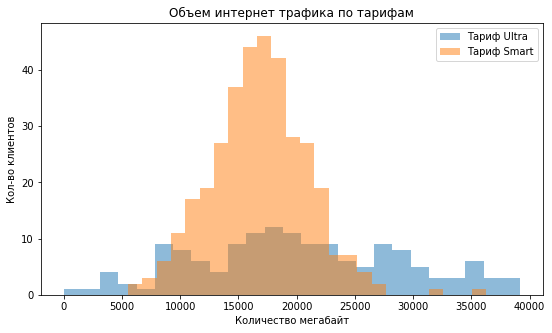

In [55]:
x = meane_values[meane_values['tariff'] == 'ultra']['mb_used']
y = meane_values[meane_values['tariff'] == 'smart']['mb_used']


plt.figure(figsize=(9, 5))
plt.hist(x, bins=25, alpha=0.5, label='Тариф Ultra')
plt.hist(y, bins=25, alpha=0.5, label='Тариф Smart')
plt.legend(loc='upper right')
plt.title('Объем интернет трафика по тарифам')
plt.xlabel('Количество мегабайт')
plt.ylabel('Кол-во клиентов')
plt.show()

* Можно сделать вывод, что большинству пользователей тарифа Smart явно не хватает пакета интернета. Очень много людей использует больше положенных 15 Гб. В сравнении с первыми, пользователи тарифа Ultra не так часто переходят за пределены установленного порога. 

**Гистограмма для сравнения количества сообщений**

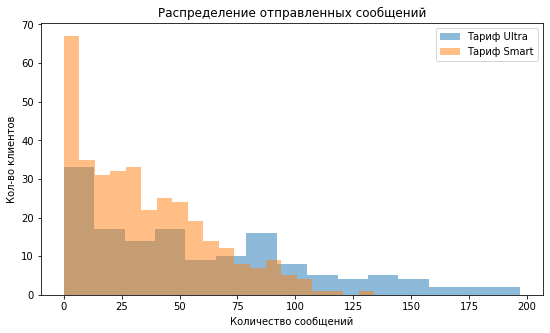

In [56]:
x = meane_values[meane_values['tariff'] == 'ultra']['messages']
y = meane_values[meane_values['tariff'] == 'smart']['messages']


plt.figure(figsize=(9, 5))
plt.hist(x, bins=15, alpha=0.5, label='Тариф Ultra')
plt.hist(y, bins=20, alpha=0.5, label='Тариф Smart')
plt.legend(loc='upper right')
plt.title('Распределение отправленных сообщений')
plt.xlabel('Количество сообщений')
plt.ylabel('Кол-во клиентов')
plt.show()

* Здесь можно заметить, что довольно много пользователей обоих тарифов вообще не пользуются сообщениями (либо отравляют меньше 5 в месяц). Однако пользователям тарифа Smart и здесь не хватает 50 сообщений в месяц и довольно много людей ежемесячно переплачивают за переписку сверх лимита. А пользователи тарифа Ultra наоборот не используют в полной мере количество включенных сообщений.

**Гистограмма для сравнения продолжительности звонков**

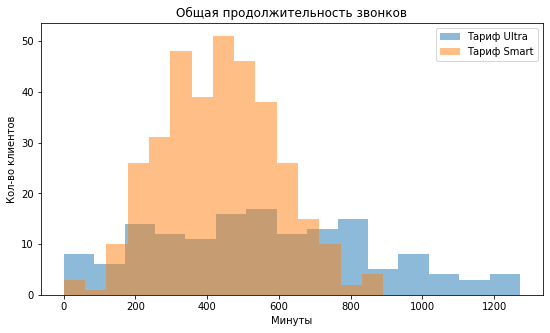

In [57]:
x = meane_values[meane_values['tariff'] == 'ultra']['duration']
y = meane_values[meane_values['tariff'] == 'smart']['duration']


plt.figure(figsize=(9, 5))
plt.hist(x, bins=15, alpha=0.5, label='Тариф Ultra')
plt.hist(y, bins=15, alpha=0.5, label='Тариф Smart')
plt.legend(loc='upper right')
plt.title('Общая продолжительность звонков')
plt.xlabel('Минуты')
plt.ylabel('Кол-во клиентов')
plt.show()

* Здесь прослеживается схожая картина, что около 30% пользователей (также исходя из описательной статистики с применением метода .describe()) тарифа Smart не хватает включенных в этот тариф минут. А пользователи Ultra не используют минуты целиком.

In [58]:
smart_user = meane_values.query('tariff == "smart"')

In [59]:
ultra_user = meane_values.query('tariff == "ultra"')

In [60]:
print('------------Тариф Smart------------')
print('Количество абонентов, использующих минуты сверх лимита: {:.0%}'.format(smart_user[smart_user['duration']>500].shape[0]/smart_user.shape[0]))
print('Количество абонентов, использующих интернет сверх лимита: {:.0%}'.format(smart_user[smart_user['mb_used']>15000].shape[0]/smart_user.shape[0]))
print('Количество абонентов, использующих больше сообщений: {:.0%}'.format(smart_user[smart_user['messages']>50].shape[0]/smart_user.shape[0]))
print('Количество абонентов, переплачивающих за тариф: {:.0%}'.format(smart_user[smart_user['earnings']>550].shape[0]/smart_user.shape[0]))


print('------------Тариф Ultra------------')
print('Количество абонентов, использующих минуты сверх лимита: {:.0%}'.format(ultra_user[ultra_user['duration']>3000].shape[0]/ultra_user.shape[0]))
print('Количество абонентов, использующих интернет сверх лимита: {:.0%}'.format(ultra_user[ultra_user['mb_used']>30000].shape[0]/ultra_user.shape[0]))
print('Количество абонентов, использующих больше сообщений: {:.0%}'.format(ultra_user[ultra_user['messages']>1000].shape[0]/ultra_user.shape[0]))
print('Количество абонентов, переплачивающих за тариф: {:.0%}'.format(ultra_user[ultra_user['earnings']>1950].shape[0]/ultra_user.shape[0]))

------------Тариф Smart------------
Количество абонентов, использующих минуты сверх лимита: 34%
Количество абонентов, использующих интернет сверх лимита: 67%
Количество абонентов, использующих больше сообщений: 25%
Количество абонентов, переплачивающих за тариф: 86%
------------Тариф Ultra------------
Количество абонентов, использующих минуты сверх лимита: 0%
Количество абонентов, использующих интернет сверх лимита: 14%
Количество абонентов, использующих больше сообщений: 0%
Количество абонентов, переплачивающих за тариф: 16%


In [61]:
# средняя выручка по тарифу
print('---------Средняя выручка с одного клиента по тарифу---------')
final_data.pivot_table(index='tariff', values='earnings', aggfunc='median')

---------Средняя выручка с одного клиента по тарифу---------


,earnings
tariff,
smart,1023.0
ultra,1950.0


### Выводы

В этом разделе мы рассчитали среднее количество, дисперсию и стандартное отклонение и рассмотрели распределение основных показателей по каждому тарифу.

Можно сделать о том, что только 14% пользователей тарифа Smart укладываются в установленные рамки, но превосходящее большинство, т.е. 86% вынуждены доплачивать в среднем 473 руб/месяц (почти 2 тарифа!!). В основном им не хватает интернет-трафика, а далее уже минут на разговоры. Оно и понятно - век интернета, вся жизнь так или иначе связа с его трафиком.

Пользователи тарифа Ultra чувствуют себя более свободно в отношении того, как им использовать возможности своего тарифа. Основная часть пользователей (около 84%) не переплачивает за тариф, в основном не используя в полной мере количество минут и количество доступных сообщений и лишь 14% нужнаются в большем объеме интернет-трафика.

## Шаг 4. Проверка гипотез

### Проверка гипотезы 1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

В Python есть специальный метод для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам: 
* scipy.stats.ttest_ind (array1, array2,equal_var)

Если параметр *equal_var* не указывать, то по умолчанию он примет значение _True_, т.е. будет считать, что наши дисперсии равны.
Но в своем случае, опираясь на полученные теоретические знания, я буду использовать «правило большого пальца»: если выборки разного размера и/или можно предположить, что дисперсии у генеральных совокупностей разные — укажем *equal_var = False* при вызове метода scipy.stats.ttest_ind().

_H0_- cредняя выручка пользователей тарифов «Ультра» и «Смарт» равны

_H1_- cредняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

Уровень значимости обычно обозначается греческой буквой «альфа». Популярными уровнями значимости являются 5%, 1% и 0.1%. Для данного исследования я приму менее строгую α = 0.05.

In [62]:
smarts = final_data.query('tariff == "smart"')['earnings'] #датасет по выручке тарифа smart
ultra = final_data.query('tariff == "ultra"')['earnings'] #датасет по выручке тарифа ultra


In [63]:
alpha = 0.05

In [64]:
results = st.ttest_ind(smarts, ultra, equal_var = False)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу, выручки тарифов различаются ")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  4.2606313931076085e-250
Отвергаем нулевую гипотезу, выручки тарифов различаются 


In [65]:
# средняя выручка по тарифу
print('---------Средняя выручка с одного клиента по тарифу---------')
final_data.pivot_table(index='tariff', values='earnings', aggfunc='median')

---------Средняя выручка с одного клиента по тарифу---------


,earnings
tariff,
smart,1023.0
ultra,1950.0


* **Результаты проведенного t-теста дают нам основание предположить, что нулевая гипотеза не верна.** Средняя выручка по тарифам различается в 2 раза в сторону тарифа Ultra.  

### Проверка гипотезы 2. Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

In [66]:
#из датасета users оставляю только 2 колонки: 1. пользователь и 2. город
users_2 = users[['user_id','city']]
users_2.head()

,user_id,city
0,1000,Краснодар
1,1001,Москва
2,1002,Стерлитамак
3,1003,Москва
4,1004,Новокузнецк


In [67]:
#объединяем данные с нашим датасетом
final_data_city = pd.merge(final_data, users_2, on=('user_id'), how='left')
final_data_city.head(15)

,user_id,month,duration,calls,messages,mb_used,tariff,earnings,city
0,1000,5.0,159.0,22.0,22.0,2253.49,ultra,1950.0,Краснодар
1,1000,6.0,172.0,43.0,60.0,23233.77,ultra,1950.0,Краснодар
2,1000,7.0,340.0,47.0,75.0,14003.64,ultra,1950.0,Краснодар
3,1000,8.0,408.0,52.0,81.0,14055.93,ultra,1950.0,Краснодар
4,1000,9.0,466.0,58.0,57.0,14568.91,ultra,1950.0,Краснодар
5,1000,10.0,350.0,57.0,73.0,14702.49,ultra,1950.0,Краснодар
6,1000,11.0,338.0,43.0,58.0,14756.47,ultra,1950.0,Краснодар
7,1000,12.0,333.0,46.0,70.0,9817.61,ultra,1950.0,Краснодар
8,1001,11.0,430.0,59.0,0.0,18429.34,smart,1150.0,Москва
9,1001,12.0,414.0,63.0,0.0,14036.66,smart,550.0,Москва


In [68]:
moscow_us = final_data_city.query('city == "Москва"')['earnings'] #датасет по выручке пользователей из Москвы
region_us = final_data_city.query('city != "Москва"')['earnings'] #датасет по выручке пользователей из Москвы

H0- cредняя выручка пользователей из Москвы не отличается (почти равна) от выручки пользователей из других регионов¶

H1- cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов¶

* Уровень значимости α = 0.05.

* equal_var = False (так же как в предыдущей гипотезе)

In [69]:
alpha = 0.05
results = st.ttest_ind(moscow_us, region_us, equal_var = False)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  0.5257376663729298
Не получилось отвергнуть нулевую гипотезу


Так как нулевую гипотезу отвергуть не получилось, то можно сделать вывод о том, что выручки пользователей из Москвы и регионов примерно равны между собой.

Можно разбить города на 2 значения: Москва и другой город. Напишем функцию, которая в новом столбце вернет это значение

In [70]:
def what_city(data):
    if data['city'] == 'Москва':
        return 'Москва'
    else:
        return 'Другой город'
    

In [71]:
final_data_city['what_city'] = final_data_city.apply(what_city, axis=1)
final_data_city.head(15)

,user_id,month,duration,calls,messages,mb_used,tariff,earnings,city,what_city
0,1000,5.0,159.0,22.0,22.0,2253.49,ultra,1950.0,Краснодар,Другой город
1,1000,6.0,172.0,43.0,60.0,23233.77,ultra,1950.0,Краснодар,Другой город
2,1000,7.0,340.0,47.0,75.0,14003.64,ultra,1950.0,Краснодар,Другой город
3,1000,8.0,408.0,52.0,81.0,14055.93,ultra,1950.0,Краснодар,Другой город
4,1000,9.0,466.0,58.0,57.0,14568.91,ultra,1950.0,Краснодар,Другой город
5,1000,10.0,350.0,57.0,73.0,14702.49,ultra,1950.0,Краснодар,Другой город
6,1000,11.0,338.0,43.0,58.0,14756.47,ultra,1950.0,Краснодар,Другой город
7,1000,12.0,333.0,46.0,70.0,9817.61,ultra,1950.0,Краснодар,Другой город
8,1001,11.0,430.0,59.0,0.0,18429.34,smart,1150.0,Москва,Москва
9,1001,12.0,414.0,63.0,0.0,14036.66,smart,550.0,Москва,Москва


In [72]:
print('---------Средняя выручка между Москвой и другими городами---------')
final_data_city.pivot_table(index='what_city', values='earnings', aggfunc='median')

---------Средняя выручка между Москвой и другими городами---------


,earnings
what_city,
Другой город,1583.0
Москва,1750.0


Средняя выручка между Москвой и другими городами различается приблизительно на 170 руб.

## Общий вывод

В этой работе был проведен анализ клиентов оператора сотовой связи "Мегалайн" на небольшой выборке в 500 человек. Стояла задача определить какой тариф приносит больше денег.
Для этого мы обработали не один, а целых 5 датасетов. Провели работу по изменению типа данных, поработали с пропущенными значениями и получили один удобный в работе датасет.

Визуализация данных помогла нам установить, что дисперсия у пользователей тарифа *Ultra* больше, чем у пользователей тарифа *Smart*. Она больше по всем показателям: минуты, интернет-трафик, сообщения; т.е. пользователи тарифа *Ultra* чувствуют себя более свободно, не задумываясь о том, как именно использовать свой пакет, а кто-то и вовсе не использует его до конца. Они обладают более широким выбором и лишь 14% клиентов переплачивает за тариф. 

Напротив - только 14% пользователей тарифа *Smart* укладываются в установленные рамки, а превосходящее большинство, т.е. 86% вынуждены доплачивать в среднем 473 руб/месяц (почти 2 тарифа!!). В основном им не хватает интернет-трафика, а далее уже минут на разговоры. Оно и понятно - век интернета, вся жизнь так или иначе связа с его трафиком.
Для принятия решения мы проверили две гипотезы, и установили:
1. что выручки по тарифам различаются. И не смотря на то, что клиенты тарифа *Smart* регулярно платят в 2 раза больше стоимости тарифа(**~1023 руб.**), выручка с тарифа *Ultra* все равно выше, т.к. даже средний платеж равен сумме тарифа - **1950 руб.**
2. между Москвой и другими регионами нет большой разницы в средней выручке, а значит, что в регионах можно запустить рекламу одного тарифа.

На формирования конечного вывода повлиял результат сравнения средней выручки по Москве и другим городам, и эти значения оказались ниже чем плата за тарифа *Ultra*, т.е. ниже 1950 руб. Поэтому более удобным и бюджетным для клиентов "Мегалайн" является тариф *Smart*, т.к. в основном, даже с учетом переплаты, за месяц выйдет сумма меньше чем 1950 руб. Поэтому скорректировать рекламный бюджет можно таким образом, чтобы было больше рекламы для тарифа *Smart*.
